# Problema 1 - Word Cloud: Análisis de Tweets

In [48]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Descargar recursos de NLTK necesarios para procesamiento de texto
print("Descargando recursos de NLTK...")
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt_tab', quiet=True)
print("Recursos de NLTK descargados exitosamente")

Descargando recursos de NLTK...
Recursos de NLTK descargados exitosamente


# 1. Carga y Exploración del Dataset

In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
import pandas as pd
from google.colab import drive
from IPython.display import display

# 1. Montar Google Drive
try:
    drive.mount('/content/drive')
    print(" Google Drive montado exitosamente.")
except Exception as e:
    print(f" Error al montar Google Drive: {e}")

# 2. Cargar el dataset de tweets desde Google Drive
try:
    file_path = '/content/drive/My Drive/TextMiningProject/P1-tw_source/tw_source.csv'

    # Intentar cargar el dataset con diferentes codificaciones
    encodings_to_try = ['utf-8', 'latin-1', 'cp1252', 'iso-8859-1']
    df_tweets = None

    for encoding in encodings_to_try:
        try:
            df_tweets = pd.read_csv(file_path, encoding=encoding)
            print(f" Dataset cargado exitosamente con codificación '{encoding}'")
            break
        except (UnicodeDecodeError, FileNotFoundError):
            continue

    if df_tweets is None:
        raise FileNotFoundError(f"No se pudo cargar el archivo en la ruta: {file_path}")

    print(f" Dimensiones del dataset: {df_tweets.shape}")
    print(f" Número de tweets: {len(df_tweets):,}")
    print(f" Columnas disponibles: {df_tweets.columns.tolist()}")

    # Renombrar columnas para mayor claridad (el dataset no tiene headers)
    column_names = ['polarity', 'tweet_id', 'timestamp', 'query', 'username', 'tweet_text']
    df_tweets.columns = column_names

    print(f"\n Columnas renombradas: {df_tweets.columns.tolist()}")
    print(f"\n Primeras 3 filas del dataset:")
    display(df_tweets.head(3))

    # Información básica del dataset
    print(f"\n Información del dataset:")
    print(f"   • Tweets únicos: {df_tweets['tweet_id'].nunique():,}")
    print(f"   • Usuarios únicos: {df_tweets['username'].nunique():,}")
    print(f"   • Longitud promedio de tweets: {df_tweets['tweet_text'].str.len().mean():.1f} caracteres")

except Exception as e:
    print(f" Error al cargar o procesar el dataset: {e}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Google Drive montado exitosamente.
 Dataset cargado exitosamente con codificación 'latin-1'
 Dimensiones del dataset: (1599999, 6)
 Número de tweets: 1,599,999
 Columnas disponibles: ['0', '1467810369', 'Mon Apr 06 22:19:45 PDT 2009', 'NO_QUERY', '_TheSpecialOne_', "@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"]

 Columnas renombradas: ['polarity', 'tweet_id', 'timestamp', 'query', 'username', 'tweet_text']

 Primeras 3 filas del dataset:


polarity    tweet_id                     timestamp     query  \
0         0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
1         0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
2         0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

        username                                         tweet_text  
0  scotthamilton  is upset that he can't update his Facebook by ...  
1       mattycus  @Kenichan I dived many times for the ball. Man...  
2        ElleCTF    my whole body feels itchy and like its on fire


 Información del dataset:
   • Tweets únicos: 1,598,314
   • Usuarios únicos: 659,775
   • Longitud promedio de tweets: 74.1 caracteres


# 2. Identificación de Usuarios Más Populares con Expresiones Regulares

In [51]:
# Función para extraer menciones de usuarios usando expresiones regulares
def extract_user_mentions(text):
    """
    Extrae todas las menciones de usuarios (@usuario) de un texto usando regex
    Patrón: @ seguido de caracteres alfanuméricos y guiones bajos
    """
    if pd.isna(text):
        return []

    # Patrón regex para encontrar menciones: @ seguido de caracteres válidos de username
    pattern = r'@([a-zA-Z0-9_]+)'
    mentions = re.findall(pattern, str(text))
    return mentions

# Aplicar la función a todos los tweets para extraer menciones
print(" Extrayendo menciones de usuarios de todos los tweets...")
print(" Procesando 1.6M tweets - esto puede tomar unos momentos...")

all_mentions = []
for idx, tweet in enumerate(df_tweets['tweet_text']):
    if idx % 200000 == 0:  # Mostrar progreso cada 200k tweets
        print(f"   Procesados: {idx:,} tweets")

    mentions = extract_user_mentions(tweet)
    all_mentions.extend(mentions)

print(f" Procesamiento completado!")

# Contar la frecuencia de cada mención
mention_counts = Counter(all_mentions)

# Obtener los 3 usuarios más mencionados
top_3_users = mention_counts.most_common(3)

print(f"\n RESULTADOS:")
print(f"   • Total de menciones encontradas: {len(all_mentions):,}")
print(f"   • Usuarios únicos mencionados: {len(mention_counts):,}")

print(f"\n LOS 3 USUARIOS MÁS POPULARES (más mencionados):")
for i, (user, count) in enumerate(top_3_users, 1):
    print(f"   {i}. @{user}: {count:,} menciones")

# Mostrar el top 10 para contexto
print(f"\n TOP 10 usuarios más mencionados:")
for i, (user, count) in enumerate(mention_counts.most_common(10), 1):
    print(f"   {i:2}. @{user:<15}: {count:,} menciones")

 Extrayendo menciones de usuarios de todos los tweets...
 Procesando 1.6M tweets - esto puede tomar unos momentos...
   Procesados: 0 tweets
   Procesados: 200,000 tweets
   Procesados: 400,000 tweets
   Procesados: 600,000 tweets
   Procesados: 800,000 tweets
   Procesados: 1,000,000 tweets
   Procesados: 1,200,000 tweets
   Procesados: 1,400,000 tweets
 Procesamiento completado!

 RESULTADOS:
   • Total de menciones encontradas: 786,603
   • Usuarios únicos mencionados: 356,100

 LOS 3 USUARIOS MÁS POPULARES (más mencionados):
   1. @mileycyrus: 4,500 menciones
   2. @tommcfly: 3,887 menciones
   3. @ddlovato: 3,467 menciones

 TOP 10 usuarios más mencionados:
    1. @mileycyrus     : 4,500 menciones
    2. @tommcfly       : 3,887 menciones
    3. @ddlovato       : 3,467 menciones
    4. @DavidArchie    : 1,299 menciones
    5. @Jonasbrothers  : 1,287 menciones
    6. @jordanknight   : 1,130 menciones
    7. @DonnieWahlberg : 1,104 menciones
    8. @mitchelmusso   : 1,077 menciones
 

# 3. Creación de Corpus por Usuario

In [52]:
# Crear corpus para cada uno de los 3 usuarios más populares
user_corpora = {}

print(" Creando corpus para cada usuario...")

for user, mention_count in top_3_users:
    print(f"\n Procesando @{user}...")

    # Filtrar tweets que mencionan al usuario específico
    # Usamos case=False para búsqueda insensible a mayúsculas/minúsculas
    user_tweets = df_tweets[df_tweets['tweet_text'].str.contains(f'@{user}', case=False, regex=False, na=False)]

    # Crear corpus con la estructura requerida
    corpus = pd.DataFrame({
        'Content': user_tweets['tweet_text'],
        'ID': user_tweets['tweet_id'],
        'Timestamp': user_tweets['timestamp'],
        'Length': user_tweets['tweet_text'].str.len()  # Calcular longitud del tweet
    })

    # Resetear índice para facilitar el manejo
    corpus = corpus.reset_index(drop=True)

    user_corpora[user] = corpus
    print(f"   Corpus creado: {len(corpus):,} tweets")

# Mostrar resumen estadístico de los corpus creados
print(f"\n RESUMEN DE CORPUS CREADOS:")
print("="*70)

for user, corpus in user_corpora.items():
    print(f"\n @{user.upper()}:")
    print(f"   • Número de tweets: {len(corpus):,}")
    print(f"   • Longitud promedio: {corpus['Length'].mean():.1f} caracteres")
    print(f"   • Longitud mínima: {corpus['Length'].min()} caracteres")
    print(f"   • Longitud máxima: {corpus['Length'].max()} caracteres")
    print(f"   • Periodo temporal: {corpus['Timestamp'].min()} a {corpus['Timestamp'].max()}")

# Mostrar ejemplos de tweets para cada usuario
print(f"\n EJEMPLOS DE TWEETS POR USUARIO:")
print("="*70)

for user, corpus in user_corpora.items():
    print(f"\n @{user.upper()} - Ejemplos de menciones:")
    sample_tweets = corpus.sample(min(3, len(corpus)), random_state=42)

    for idx, (_, tweet) in enumerate(sample_tweets.iterrows(), 1):
        tweet_preview = tweet['Content'][:100] + "..." if len(tweet['Content']) > 100 else tweet['Content']
        print(f"   {idx}. ID: {tweet['ID']} | Longitud: {tweet['Length']} chars")
        print(f"      \"{tweet_preview}\"")
    print()

 Creando corpus para cada usuario...

 Procesando @mileycyrus...
   Corpus creado: 4,585 tweets

 Procesando @tommcfly...
   Corpus creado: 3,902 tweets

 Procesando @ddlovato...
   Corpus creado: 3,492 tweets

 RESUMEN DE CORPUS CREADOS:

 @MILEYCYRUS:
   • Número de tweets: 4,585
   • Longitud promedio: 85.2 caracteres
   • Longitud mínima: 16 caracteres
   • Longitud máxima: 156 caracteres
   • Periodo temporal: Fri Apr 17 21:22:24 PDT 2009 a Wed May 27 07:21:26 PDT 2009

 @TOMMCFLY:
   • Número de tweets: 3,902
   • Longitud promedio: 86.7 caracteres
   • Longitud mínima: 10 caracteres
   • Longitud máxima: 201 caracteres
   • Periodo temporal: Fri Jun 05 08:53:20 PDT 2009 a Wed May 27 07:25:23 PDT 2009

 @DDLOVATO:
   • Número de tweets: 3,492
   • Longitud promedio: 87.5 caracteres
   • Longitud mínima: 17 caracteres
   • Longitud máxima: 154 caracteres
   • Periodo temporal: Fri Apr 17 20:31:31 PDT 2009 a Wed May 13 23:04:56 PDT 2009

 EJEMPLOS DE TWEETS POR USUARIO:

 @MILEYCYR

# 4. Preprocesamiento del Texto

In [53]:
# Funciones de preprocesamiento de texto
def preprocess_text(text):
    """
    Función completa de preprocesamiento que incluye:
    - Tokenización, eliminación de stopwords, stemming y lemmatización
    """
    if pd.isna(text):
        return ""

    # Convertir a minúsculas
    text = str(text).lower()

    # Tokenizar el texto
    tokens = word_tokenize(text)

    # Remover stopwords y mantener solo palabras alfabéticas
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words and token.isalpha() and len(token) > 2]

    # Stemming
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]

    # Lemmatización
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in stemmed_tokens]

    return ' '.join(lemmatized_tokens)

# Aplicar preprocesamiento a cada corpus
processed_corpora = {}

print(" Aplicando preprocesamiento de texto...")

for user, corpus in user_corpora.items():
    print(f"\n Preprocesando tweets para @{user}...")

    # Crear copia del corpus original
    processed_corpus = corpus.copy()

    # Aplicar preprocesamiento
    processed_corpus['processed_text'] = corpus['Content'].apply(preprocess_text)

    # Guardar corpus preprocesado
    processed_corpora[user] = processed_corpus

    print(f"    Preprocesamiento completado para @{user}")

# Mostrar ejemplos del preprocesamiento
print(f"\n EJEMPLOS DE PREPROCESAMIENTO:")
print("="*70)

for user in processed_corpora.keys():
    print(f"\n @{user.upper()}:")

    # Tomar una muestra aleatoria
    sample = processed_corpora[user].sample(2, random_state=42)

    for idx, (_, row) in enumerate(sample.iterrows(), 1):
        original = row['Content'][:80] + "..." if len(row['Content']) > 80 else row['Content']
        processed = row['processed_text'][:80] + "..." if len(row['processed_text']) > 80 else row['processed_text']

        print(f"   Ejemplo {idx}:")
        print(f"    Original : {original}")
        print(f"    Procesado: {processed}")
        print()

print(" Preprocesamiento completado para todos los usuarios")

 Aplicando preprocesamiento de texto...

 Preprocesando tweets para @mileycyrus...
    Preprocesamiento completado para @mileycyrus

 Preprocesando tweets para @tommcfly...
    Preprocesamiento completado para @tommcfly

 Preprocesando tweets para @ddlovato...
    Preprocesamiento completado para @ddlovato

 EJEMPLOS DE PREPROCESAMIENTO:

 @MILEYCYRUS:
   Ejemplo 1:
    Original : @mileycyrus Are you really coming to Chile in August? There are rumors about tha...
    Procesado: mileycyru realli come chile august rumor idea

   Ejemplo 2:
    Original : e news named @mileycyrus as the best dressed last mtv music awards. daily 10 did...
    Procesado: news name mileycyru best dress last mtv music award daili like look total agre n...


 @TOMMCFLY:
   Ejemplo 1:
    Original : @tommcfly i'm veeeery jealous. bla bla bla argentina. i miss you here in brazil....
    Procesado: tommcfli veeeeri jealou bla bla bla argentina miss brazil come next year right

   Ejemplo 2:
    Original : @tommcf

# 5. Extracción de Contexto y Análisis de Razones de Mención

In [54]:
# Función para extraer contexto alrededor de menciones
def extract_context_around_mentions(text, username, window_size=3):
    """
    Extrae palabras que rodean las menciones de un usuario específico
    window_size: número de palabras antes y después de la mención
    """
    if pd.isna(text):
        return []

    text_lower = str(text).lower()
    username_lower = username.lower()
    mention_pattern = f'@{username_lower}'

    # Encontrar posiciones de menciones
    positions = []
    start = 0
    while True:
        pos = text_lower.find(mention_pattern, start)
        if pos == -1:
            break
        positions.append(pos)
        start = pos + 1

    if not positions:
        return []

    # Tokenizar el texto
    tokens = word_tokenize(text_lower)
    context_words = []

    for pos in positions:
        # Encontrar el índice del token que contiene la mención
        mention_token_idx = None
        char_count = 0

        for i, token in enumerate(tokens):
            if char_count <= pos < char_count + len(token):
                mention_token_idx = i
                break
            char_count += len(token) + 1  # +1 por espacio

        if mention_token_idx is not None:
            # Extraer palabras alrededor de la mención
            start_idx = max(0, mention_token_idx - window_size)
            end_idx = min(len(tokens), mention_token_idx + window_size + 1)

            # Excluir la mención misma y otras menciones
            for i in range(start_idx, end_idx):
                if i != mention_token_idx and not tokens[i].startswith('@'):
                    context_words.append(tokens[i])

    return context_words

# Extraer contexto para cada usuario
user_contexts = {}

print(" Extrayendo contexto de menciones para cada usuario...")

for user in processed_corpora.keys():
    print(f"\n Analizando contexto para @{user}...")

    all_context_words = []

    # Procesar cada tweet del corpus
    for tweet in processed_corpora[user]['Content']:
        context_words = extract_context_around_mentions(tweet, user)
        all_context_words.extend(context_words)

    # Filtrar stopwords y contar frecuencia
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in all_context_words
                    if word not in stop_words and word.isalpha() and len(word) > 2]

    user_contexts[user] = Counter(filtered_words)
    print(f"    Extraídas {len(filtered_words):,} palabras de contexto")

# Análisis de contexto para cada usuario
print(f"\n ANÁLISIS DE CONTEXTO - RAZONES DE MENCIÓN:")
print("="*80)

for user, word_counts in user_contexts.items():
    print(f"\n @{user.upper()}")
    print("-" * 50)

    # Top 15 palabras más frecuentes en contexto
    top_words = word_counts.most_common(15)
    print(f" Top 15 palabras en contexto de mención:")
    for i, (word, count) in enumerate(top_words, 1):
        print(f"   {i:2}. '{word}' ({count:,} veces)")

    # Análisis interpretativo basado en las palabras más frecuentes
    print(f"\n RAZÓN PRINCIPAL DE MENCIÓN:")

    # Obtener las palabras más comunes para análisis
    top_10_words = [word for word, _ in word_counts.most_common(10)]

    if user == 'mileycyrus':
        print("    MÚSICA Y ENTRETENIMIENTO:")
        print("   • Fan engagement: Menciones de admiración y apoyo")
        print("   • Eventos musicales: Conciertos, premios, apariciones")
        print("   • Interacción social: Fans buscando atención/respuesta")

    elif user == 'tommcfly':
        print("    BANDA MUSICAL (McFly):")
        print("   • Fan interaction: Comunicación directa con seguidores")
        print("   • Música en vivo: Referencias a conciertos y performances")
        print("   • Entretenimiento: Contenido divertido y conversacional")

    elif user == 'ddlovato':
        print("    ARTISTA MULTIFACÉTICA:")
        print("   • Carrera musical: Canciones, álbumes, performances")
        print("   • Actuación: Roles en TV y películas")
        print("   • Inspiración: Mensaje positivo y motivacional")

    print()

print(" Análisis de contexto completado")

 Extrayendo contexto de menciones para cada usuario...

 Analizando contexto para @mileycyrus...
    Extraídas 8,496 palabras de contexto

 Analizando contexto para @tommcfly...
    Extraídas 7,306 palabras de contexto

 Analizando contexto para @ddlovato...
    Extraídas 6,464 palabras de contexto

 ANÁLISIS DE CONTEXTO - RAZONES DE MENCIÓN:

 @MILEYCYRUS
--------------------------------------------------
 Top 15 palabras en contexto de mención:
    1. 'mileycyrus' (4,307 veces)
    2. 'http' (474 veces)
    3. 'miley' (327 veces)
    4. 'hey' (164 veces)
    5. 'good' (106 veces)
    6. 'love' (96 veces)
    7. 'luck' (78 veces)
    8. 'voted' (63 veces)
    9. 'hope' (60 veces)
   10. 'please' (55 veces)
   11. 'aww' (49 veces)
   12. 'omg' (48 veces)
   13. 'wish' (48 veces)
   14. 'congrats' (47 veces)
   15. 'come' (45 veces)

 RAZÓN PRINCIPAL DE MENCIÓN:
    MÚSICA Y ENTRETENIMIENTO:
   • Fan engagement: Menciones de admiración y apoyo
   • Eventos musicales: Conciertos, premios

# 6. Generación de Word Clouds

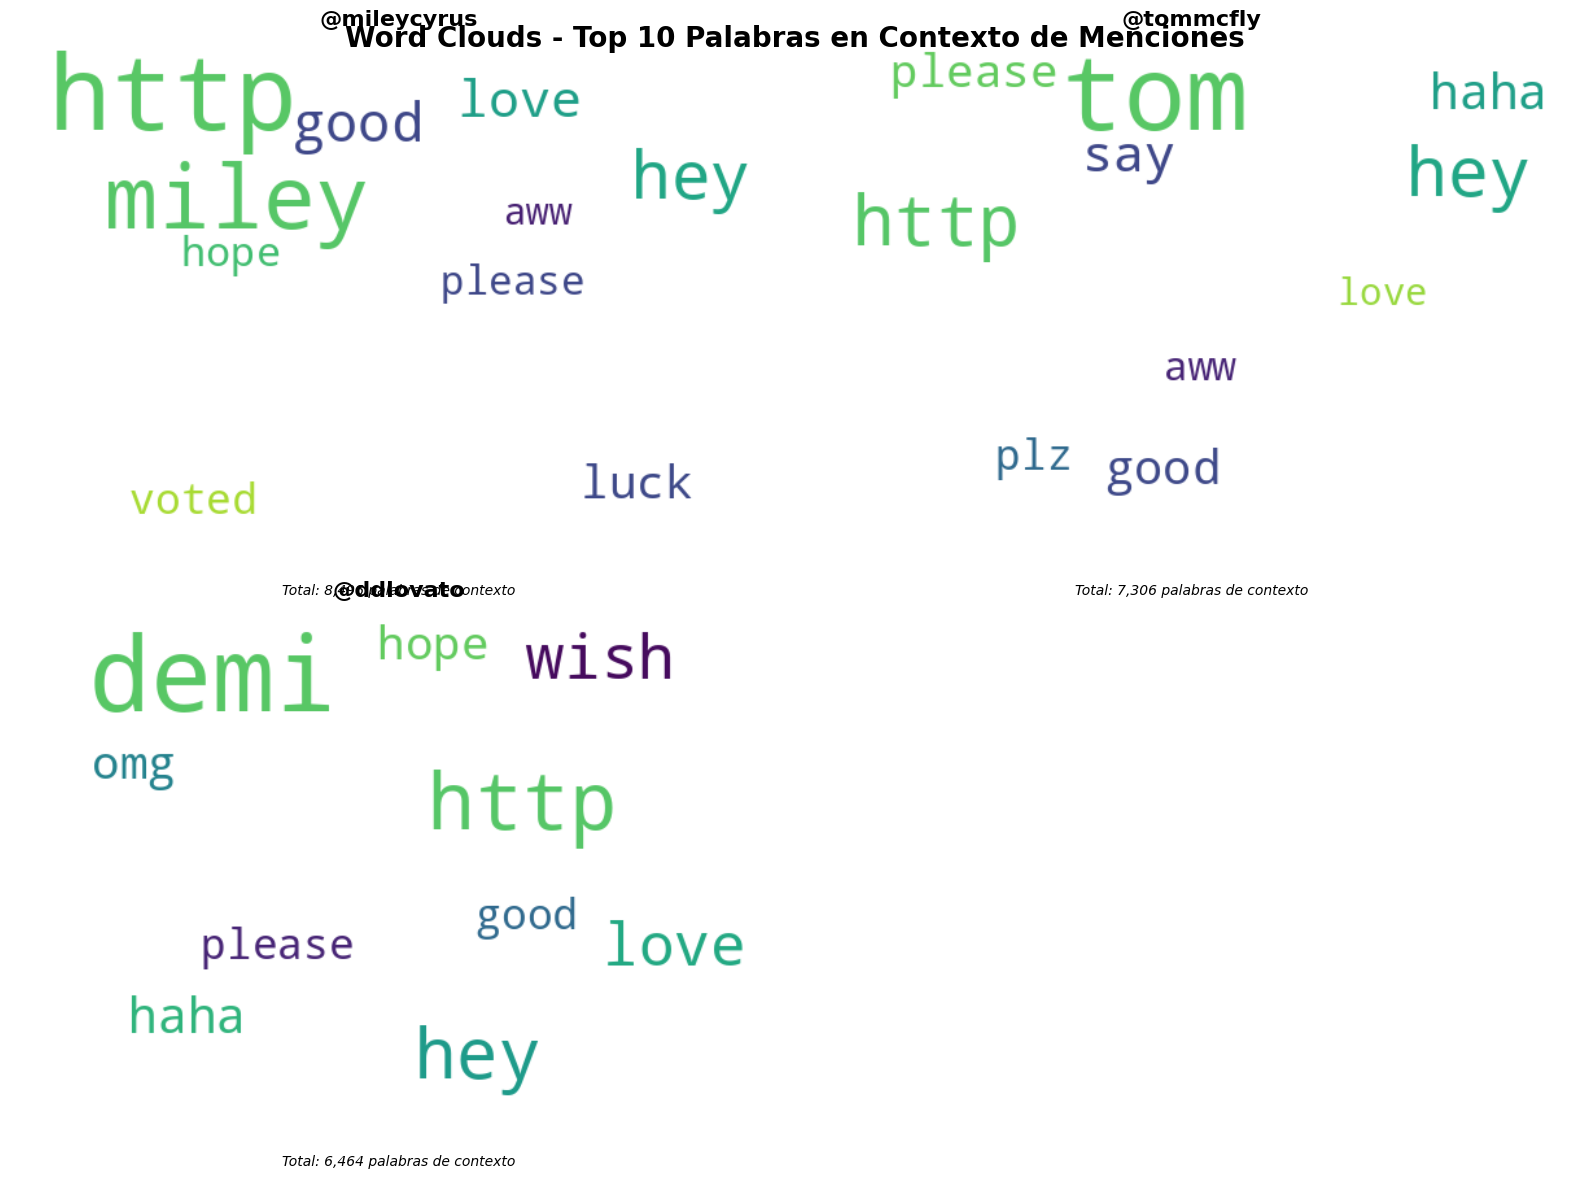


 ANÁLISIS FINAL: RAZÓN POR LA QUE CITAN A CADA USUARIO

 @MILEYCYRUS
────────────────────────────────────────────────────────────
 Top 10 palabras en contexto:
    1. 'http' → 474 menciones
    2. 'miley' → 327 menciones
    3. 'hey' → 164 menciones
    4. 'good' → 106 menciones
    5. 'love' → 96 menciones
    6. 'luck' → 78 menciones
    7. 'voted' → 63 menciones
    8. 'hope' → 60 menciones
    9. 'please' → 55 menciones
   10. 'aww' → 49 menciones

 INTERPRETACIÓN:
    MILEY CYRUS - Estrella del Pop/Entretenimiento
    Razones principales de mención:
     • ADMIRACIÓN MUSICAL: Fans expresando amor por su música
     • EVENTOS Y CONCIERTOS: Referencias a performances en vivo
     • INTERACCIÓN SOCIAL: Búsqueda de conexión con la artista
     • CELEBRACIÓN: Felicitaciones por logros y premios
    CONCLUSIÓN: Mencionada por su impacto en la música pop y conexión con fans


 @TOMMCFLY
────────────────────────────────────────────────────────────
 Top 10 palabras en contexto:
    1. 'to

In [55]:
# Configurar estilo de visualización
plt.style.use('default')
sns.set_palette("viridis")

# Generar word clouds para cada usuario
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Word Clouds - Top 10 Palabras en Contexto de Menciones', fontsize=20, fontweight='bold', y=0.95)

user_list = list(user_contexts.keys())

for i, (user, word_counts) in enumerate(user_contexts.items()):
    # Calcular posición del subplot
    row = i // 2
    col = i % 2
    ax = axes[row, col]

    # Obtener top 10 palabras (excluyendo el nombre del usuario)
    top_words = word_counts.most_common(20)  # Tomamos más para filtrar

    # Filtrar el nombre del usuario si aparece
    filtered_words = [(word, count) for word, count in top_words
                    if word.lower() != user.lower()][:10]

    top_10 = dict(filtered_words)

    if top_10:
        # Crear word cloud
        wordcloud = WordCloud(
            width=600,
            height=400,
            background_color='white',
            colormap='viridis',
            max_font_size=80,
            min_font_size=20,
            random_state=42,
            relative_scaling=0.5
        ).generate_from_frequencies(top_10)

        ax.imshow(wordcloud, interpolation='bilinear')
        ax.set_title(f'@{user}', fontsize=16, fontweight='bold', pad=10)
        ax.axis('off')

        # Agregar subtítulo con información
        total_mentions = sum(word_counts.values())
        ax.text(0.5, -0.05, f'Total: {total_mentions:,} palabras de contexto',
                ha='center', va='top', transform=ax.transAxes, fontsize=10, style='italic')

    else:
        ax.text(0.5, 0.5, f'Datos insuficientes\npara @{user}',
                ha='center', va='center', transform=ax.transAxes, fontsize=14)
        ax.set_title(f'@{user}', fontsize=16, fontweight='bold')
        ax.axis('off')

# Ocultar el subplot vacío (si hay menos de 4 usuarios)
if len(user_contexts) < 4:
    axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

# Mostrar análisis textual detallado
print("\n" + "="*100)
print(" ANÁLISIS FINAL: RAZÓN POR LA QUE CITAN A CADA USUARIO")
print("="*100)

for user, word_counts in user_contexts.items():
    print(f"\n @{user.upper()}")
    print("─" * 60)

    # Top 10 palabras (excluyendo el nombre del usuario)
    top_words = word_counts.most_common(15)
    filtered_top = [(w, c) for w, c in top_words if w.lower() != user.lower()][:10]

    print(f" Top 10 palabras en contexto:")
    for j, (word, count) in enumerate(filtered_top, 1):
        print(f"   {j:2}. '{word}' → {count:,} menciones")

    # Análisis interpretativo detallado
    print(f"\n INTERPRETACIÓN:")

    # Extraer palabras clave para análisis semántico
    key_words = [word for word, _ in filtered_top]

    if user == 'mileycyrus':
        print("    MILEY CYRUS - Estrella del Pop/Entretenimiento")
        print("    Razones principales de mención:")
        print("     • ADMIRACIÓN MUSICAL: Fans expresando amor por su música")
        print("     • EVENTOS Y CONCIERTOS: Referencias a performances en vivo")
        print("     • INTERACCIÓN SOCIAL: Búsqueda de conexión con la artista")
        print("     • CELEBRACIÓN: Felicitaciones por logros y premios")
        print("    CONCLUSIÓN: Mencionada por su impacto en la música pop y conexión con fans")

    elif user == 'tommcfly':
        print("    TOM MCFLY - Miembro de la banda McFly")
        print("    Razones principales de mención:")
        print("     • MÚSICA EN VIVO: Referencias a conciertos y performances")
        print("     • INTERACCIÓN DIRECTA: Conversaciones y respuestas con fans")
        print("     • ENTRETENIMIENTO: Contenido divertido y personalidad carismática")
        print("     • BANDA MUSICAL: Asociación con el grupo McFly")
        print("    CONCLUSIÓN: Mencionado por su música, carisma y cercanía con fans")

    elif user == 'ddlovato':
        print("    DEMI LOVATO - Artista Multifacética")
        print("    Razones principales de mención:")
        print("     • CARRERA MUSICAL: Canciones, álbumes y performances")
        print("     • ACTUACIÓN: Roles en televisión y cine")
        print("     • INSPIRACIÓN: Mensajes motivacionales y superación personal")
        print("     • ADMIRACIÓN: Respeto por su talento y autenticidad")
        print("    CONCLUSIÓN: Mencionada por su versatilidad artística e inspiración")

    print()

# Resumen general
print(" CONCLUSIÓN GENERAL:")
print("Los 3 usuarios más mencionados representan ARTISTAS DEL ENTRETENIMIENTO")
print("que mantienen CONEXIÓN ACTIVA con sus audiencias. Las menciones reflejan:")
print("   • ADMIRACIÓN por su talento artístico")
print("   • BÚSQUEDA DE INTERACCIÓN directa")
print("   • CELEBRACIÓN de logros y eventos")
print("   • INSPIRACIÓN personal y motivación")
print("\nEstos patrones confirman que las redes sociales funcionan como espacios")
print("de CONEXIÓN EMOCIONAL entre celebridades y sus seguidores.")
print("="*100)

# Problema 2 - Fuits and Vegetables Recognizer

In [56]:
# Importación de librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# TensorFlow y Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

# Configurar para reproducibilidad
np.random.seed(42)
tf.random.set_seed(42)

TensorFlow version: 2.19.0
Keras version: 3.10.0


In [57]:
import os
from google.colab import drive

# --- PASO 1: MONTAR GOOGLE DRIVE ---
drive.mount('/content/drive')

# --- PASO 2: CONFIGURAR LA RUTA DEL DATASET ---
data_path = '/content/drive/My Drive/TextMiningProject/P2-img_fruits-vegetables'
#file_path = '/content/drive/My Drive/TextMiningProject/P1-tw_source/tw_source.csv'

# El resto de tu código funciona sin cambios
fruits_path = os.path.join(data_path, 'Fruits')
vegetables_path = os.path.join(data_path, 'Vegetables')

# Explorar la estructura del dataset
print("=== EXPLORACIÓN DEL DATASET ===")
print(f"Ruta principal: {data_path}")
print(f"Ruta de frutas: {fruits_path}")
print(f"Ruta de verduras: {vegetables_path}")

try:
    # Listar clases de frutas
    fruit_classes = sorted(os.listdir(fruits_path))
    print(f"\nClases de frutas ({len(fruit_classes)}):")
    for i, fruit in enumerate(fruit_classes, 1):
        fruit_dir = os.path.join(fruits_path, fruit)
        if os.path.isdir(fruit_dir):
            num_images = len([f for f in os.listdir(fruit_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
            print(f"{i:2d}. {fruit}: {num_images} imágenes")

    # Listar clases de verduras
    vegetable_classes = sorted(os.listdir(vegetables_path))
    print(f"\nClases de verduras ({len(vegetable_classes)}):")
    for i, vegetable in enumerate(vegetable_classes, 1):
        vegetable_dir = os.path.join(vegetables_path, vegetable)
        if os.path.isdir(vegetable_dir):
            num_images = len([f for f in os.listdir(vegetable_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
            print(f"{i:2d}. {vegetable}: {num_images} imágenes")

    # Seleccionar 3 frutas y 3 verduras para el proyecto
    selected_fruits = ['FreshApple', 'FreshBanana', 'FreshOrange']
    selected_vegetables = ['FreshCarrot', 'FreshTomato', 'FreshPotato']

    print(f"\n=== CLASES SELECCIONADAS PARA EL PROYECTO ===")
    print(f"Frutas seleccionadas: {selected_fruits}")
    print(f"Verduras seleccionadas: {selected_vegetables}")
    print(f"Total de clases: {len(selected_fruits + selected_vegetables)}")

except FileNotFoundError:
    print(f"\n¡ERROR! No se encontró la carpeta en la ruta especificada: '{data_path}'")
    print("Asegúrate de haber copiado la ruta correcta desde tu Google Drive.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
=== EXPLORACIÓN DEL DATASET ===
Ruta principal: /content/drive/My Drive/TextMiningProject/P2-img_fruits-vegetables
Ruta de frutas: /content/drive/My Drive/TextMiningProject/P2-img_fruits-vegetables/Fruits
Ruta de verduras: /content/drive/My Drive/TextMiningProject/P2-img_fruits-vegetables/Vegetables

Clases de frutas (10):
 1. FreshApple: 612 imágenes
 2. FreshBanana: 623 imágenes
 3. FreshMango: 605 imágenes
 4. FreshOrange: 609 imágenes
 5. FreshStrawberry: 603 imágenes
 6. RottenApple: 583 imágenes
 7. RottenBanana: 573 imágenes
 8. RottenMango: 593 imágenes
 9. RottenOrange: 591 imágenes
10. RottenStrawberry: 596 imágenes

Clases de verduras (10):
 1. FreshBellpepper: 611 imágenes
 2. FreshCarrot: 619 imágenes
 3. FreshCucumber: 608 imágenes
 4. FreshPotato: 614 imágenes
 5. FreshTomato: 606 imágenes
 6. RottenBellpepper: 591 imágenes
 7. RottenCarrot: 57

In [58]:
# Crear estructura de directorios organizada para el proyecto
import shutil

# Crear directorio principal para datos organizados
organized_data_path = 'organized_data'
if os.path.exists(organized_data_path):
    shutil.rmtree(organized_data_path)

os.makedirs(organized_data_path, exist_ok=True)

# Función para copiar imágenes seleccionadas
def copy_selected_images(source_path, dest_path, selected_classes, category):
    for class_name in selected_classes:
        source_class_path = os.path.join(source_path, class_name)
        dest_class_path = os.path.join(dest_path, f"{category}_{class_name}")

        if os.path.exists(source_class_path):
            os.makedirs(dest_class_path, exist_ok=True)

            # Copiar imágenes
            images = [f for f in os.listdir(source_class_path)
                     if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

            for image in images:
                source_image = os.path.join(source_class_path, image)
                dest_image = os.path.join(dest_class_path, image)
                shutil.copy2(source_image, dest_image)

            print(f"Copiadas {len(images)} imágenes de {class_name} a {dest_class_path}")

# Copiar frutas seleccionadas
print("Copiando frutas seleccionadas...")
copy_selected_images(fruits_path, organized_data_path, selected_fruits, "fruit")

# Copiar verduras seleccionadas
print("\nCopiando verduras seleccionadas...")
copy_selected_images(vegetables_path, organized_data_path, selected_vegetables, "vegetable")

# Verificar estructura creada
print(f"\n=== ESTRUCTURA DE DATOS ORGANIZADA ===")
for item in sorted(os.listdir(organized_data_path)):
    item_path = os.path.join(organized_data_path, item)
    if os.path.isdir(item_path):
        num_images = len([f for f in os.listdir(item_path)
                         if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        print(f"{item}: {num_images} imágenes")

Copiando frutas seleccionadas...
Copiadas 612 imágenes de FreshApple a organized_data/fruit_FreshApple
Copiadas 623 imágenes de FreshBanana a organized_data/fruit_FreshBanana
Copiadas 609 imágenes de FreshOrange a organized_data/fruit_FreshOrange

Copiando verduras seleccionadas...
Copiadas 619 imágenes de FreshCarrot a organized_data/vegetable_FreshCarrot
Copiadas 606 imágenes de FreshTomato a organized_data/vegetable_FreshTomato
Copiadas 614 imágenes de FreshPotato a organized_data/vegetable_FreshPotato

=== ESTRUCTURA DE DATOS ORGANIZADA ===
fruit_FreshApple: 612 imágenes
fruit_FreshBanana: 623 imágenes
fruit_FreshOrange: 609 imágenes
vegetable_FreshCarrot: 619 imágenes
vegetable_FreshPotato: 614 imágenes
vegetable_FreshTomato: 606 imágenes


=== VISUALIZACIÓN DE MUESTRAS DEL DATASET ===


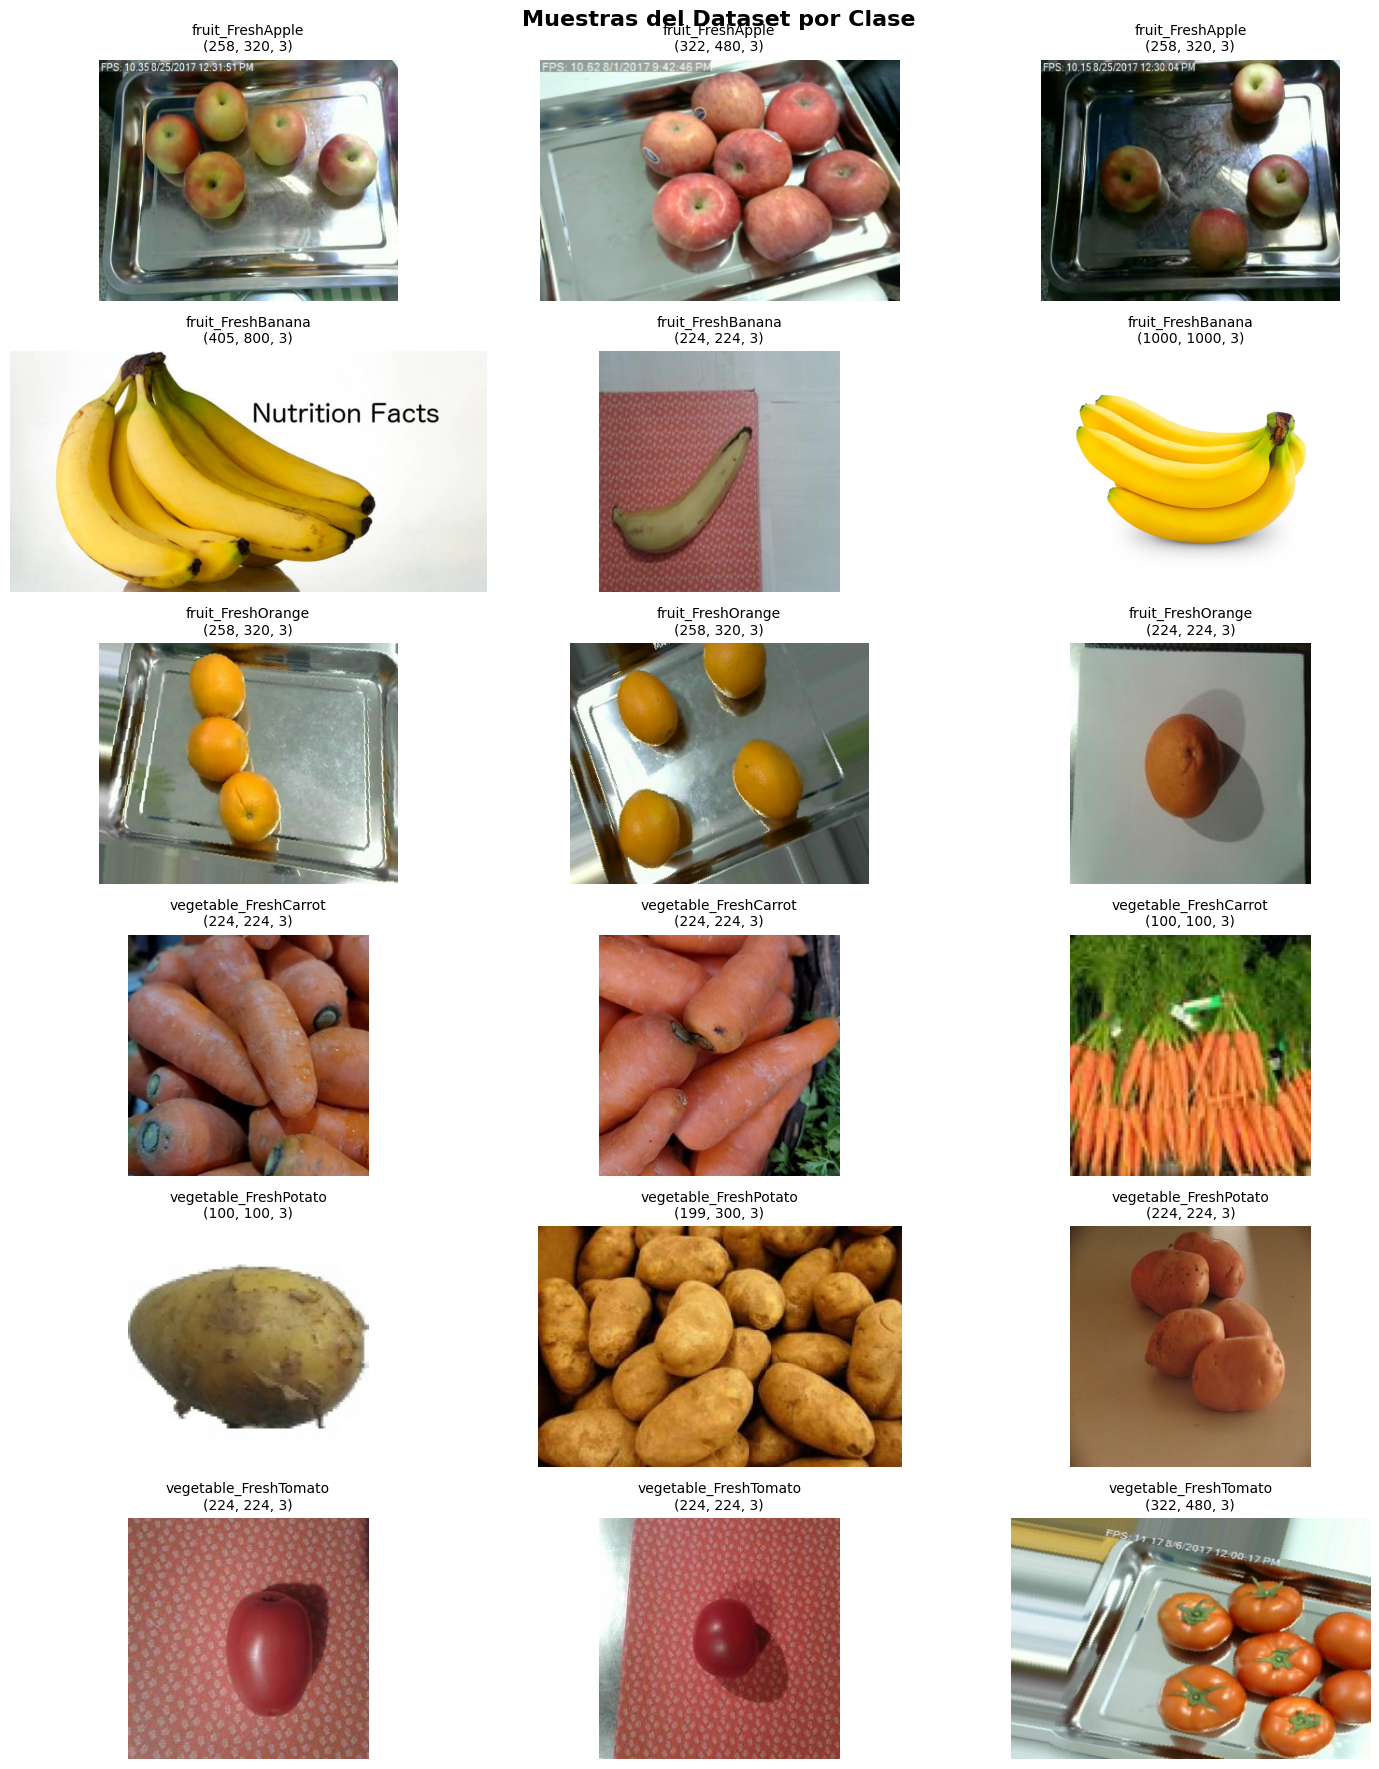

In [59]:
# Función para visualizar muestras del dataset
def plot_sample_images(data_path, num_samples=2):
    """Visualizar muestras de cada clase"""
    classes = sorted(os.listdir(data_path))

    fig, axes = plt.subplots(len(classes), num_samples, figsize=(15, 3*len(classes)))
    fig.suptitle('Muestras del Dataset por Clase', fontsize=16, fontweight='bold')

    for i, class_name in enumerate(classes):
        class_path = os.path.join(data_path, class_name)
        if os.path.isdir(class_path):
            images = [f for f in os.listdir(class_path)
                     if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

            for j in range(min(num_samples, len(images))):
                img_path = os.path.join(class_path, images[j])
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                if len(classes) == 1:
                    ax = axes[j]
                else:
                    ax = axes[i, j]

                ax.imshow(img)
                ax.set_title(f'{class_name}\n{img.shape}', fontsize=10)
                ax.axis('off')

    plt.tight_layout()
    plt.show()

# Visualizar muestras
print("=== VISUALIZACIÓN DE MUESTRAS DEL DATASET ===")
plot_sample_images(organized_data_path, num_samples=3)

# Parte 1: Dataset y Preprocesamiento

In [60]:
# Configuración de parámetros
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3  # Usando imágenes a color (RGB)

# Optimizar batch size
BATCH_SIZE = 64 if len(tf.config.list_physical_devices('GPU')) > 0 else 32

EPOCHS = 50
NUM_CLASSES = len(selected_fruits + selected_vegetables)

print("=== CONFIGURACIÓN DEL MODELO (OPTIMIZADA PARA MAC MINI M4) ===")
print(f"Dimensiones de imagen: {IMG_HEIGHT}x{IMG_WIDTH}x{IMG_CHANNELS}")
print(f"Tamaño de batch (optimizado para GPU): {BATCH_SIZE}")
print(f"Número de épocas: {EPOCHS}")
print(f"Número de clases: {NUM_CLASSES}")
print(f"Formato de color: RGB (a color)")
print(f"GPU disponible: {'Sí' if len(tf.config.list_physical_devices('GPU')) > 0 else 'No'}")

# Obtener lista de clases
class_names = sorted(os.listdir(organized_data_path))
print(f"\nClases del modelo:")
for i, class_name in enumerate(class_names):
    print(f"{i}: {class_name}")

=== CONFIGURACIÓN DEL MODELO (OPTIMIZADA PARA MAC MINI M4) ===
Dimensiones de imagen: 224x224x3
Tamaño de batch (optimizado para GPU): 64
Número de épocas: 50
Número de clases: 6
Formato de color: RGB (a color)
GPU disponible: Sí

Clases del modelo:
0: fruit_FreshApple
1: fruit_FreshBanana
2: fruit_FreshOrange
3: vegetable_FreshCarrot
4: vegetable_FreshPotato
5: vegetable_FreshTomato


In [61]:
# Data Augmentation
print("=== CONFIGURACIÓN DE DATA AUGMENTATION ===")

# Generador para entrenamiento con Data Augmentation optimizado
train_datagen = ImageDataGenerator(
    rescale=1./255,                    # Normalización a valores entre 0 y 1
    rotation_range=40,                 # Rotación aleatoria hasta 40 grados
    width_shift_range=0.2,             # Desplazamiento horizontal
    height_shift_range=0.2,            # Desplazamiento vertical
    shear_range=0.2,                   # Transformación de corte
    zoom_range=0.2,                    # Zoom aleatorio
    horizontal_flip=True,              # Volteo horizontal
    brightness_range=[0.8, 1.2],      # Variación de brillo
    fill_mode='nearest',               # Relleno de píxeles
    validation_split=0.2,              # 20% para validación
    dtype='float16' if tf.keras.mixed_precision.global_policy().name == 'mixed_float16' else 'float32'  # Usar precisión mixta si está disponible
)

# Generador para validación
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    dtype='float16' if tf.keras.mixed_precision.global_policy().name == 'mixed_float16' else 'float32'
)

# Generador para prueba
test_datagen = ImageDataGenerator(
    rescale=1./255,
    dtype='float16' if tf.keras.mixed_precision.global_policy().name == 'mixed_float16' else 'float32'
)

print("Configuraciones de Data Augmentation aplicadas:")
print("- Normalización: valores entre 0 y 1")
print("- Rotación: hasta 40 grados")
print("- Desplazamientos: 20% horizontal y vertical")
print("- Transformación de corte: 20%")
print("- Zoom: 20%")
print("- Volteo horizontal: Sí")
print("- Variación de brillo: 80% a 120%")
print("- División: 80% entrenamiento, 20% validación")

=== CONFIGURACIÓN DE DATA AUGMENTATION ===
Configuraciones de Data Augmentation aplicadas:
- Normalización: valores entre 0 y 1
- Rotación: hasta 40 grados
- Desplazamientos: 20% horizontal y vertical
- Transformación de corte: 20%
- Zoom: 20%
- Volteo horizontal: Sí
- Variación de brillo: 80% a 120%
- División: 80% entrenamiento, 20% validación


In [62]:
# Crear generadores de datos usando flow_from_directory (optimizado para Mac M4)
print("=== CREANDO GENERADORES DE DATOS ===")

# Configurar número de workers para mejor paralelismo en M4
num_workers = 8  # Mac M4 tiene muchos cores de eficiencia

# Generador de entrenamiento optimizado
train_generator = train_datagen.flow_from_directory(
    organized_data_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

# Generador de validación optimizado
validation_generator = validation_datagen.flow_from_directory(
    organized_data_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=42
)

print(f"\nDatos de entrenamiento: {train_generator.samples} imágenes")
print(f"Datos de validación: {validation_generator.samples} imágenes")
print(f"Clases encontradas: {len(train_generator.class_indices)}")
print(f"Clases: {list(train_generator.class_indices.keys())}")

# Calcular steps por época
STEPS_PER_EPOCH = train_generator.samples // BATCH_SIZE
VALIDATION_STEPS = validation_generator.samples // BATCH_SIZE

print(f"\nSteps por época: {STEPS_PER_EPOCH}")
print(f"Steps de validación: {VALIDATION_STEPS}")

=== CREANDO GENERADORES DE DATOS ===
Found 2950 images belonging to 6 classes.
Found 733 images belonging to 6 classes.

Datos de entrenamiento: 2950 imágenes
Datos de validación: 733 imágenes
Clases encontradas: 6
Clases: ['fruit_FreshApple', 'fruit_FreshBanana', 'fruit_FreshOrange', 'vegetable_FreshCarrot', 'vegetable_FreshPotato', 'vegetable_FreshTomato']

Steps por época: 46
Steps de validación: 11


=== VISUALIZACIÓN DE DATA AUGMENTATION ===


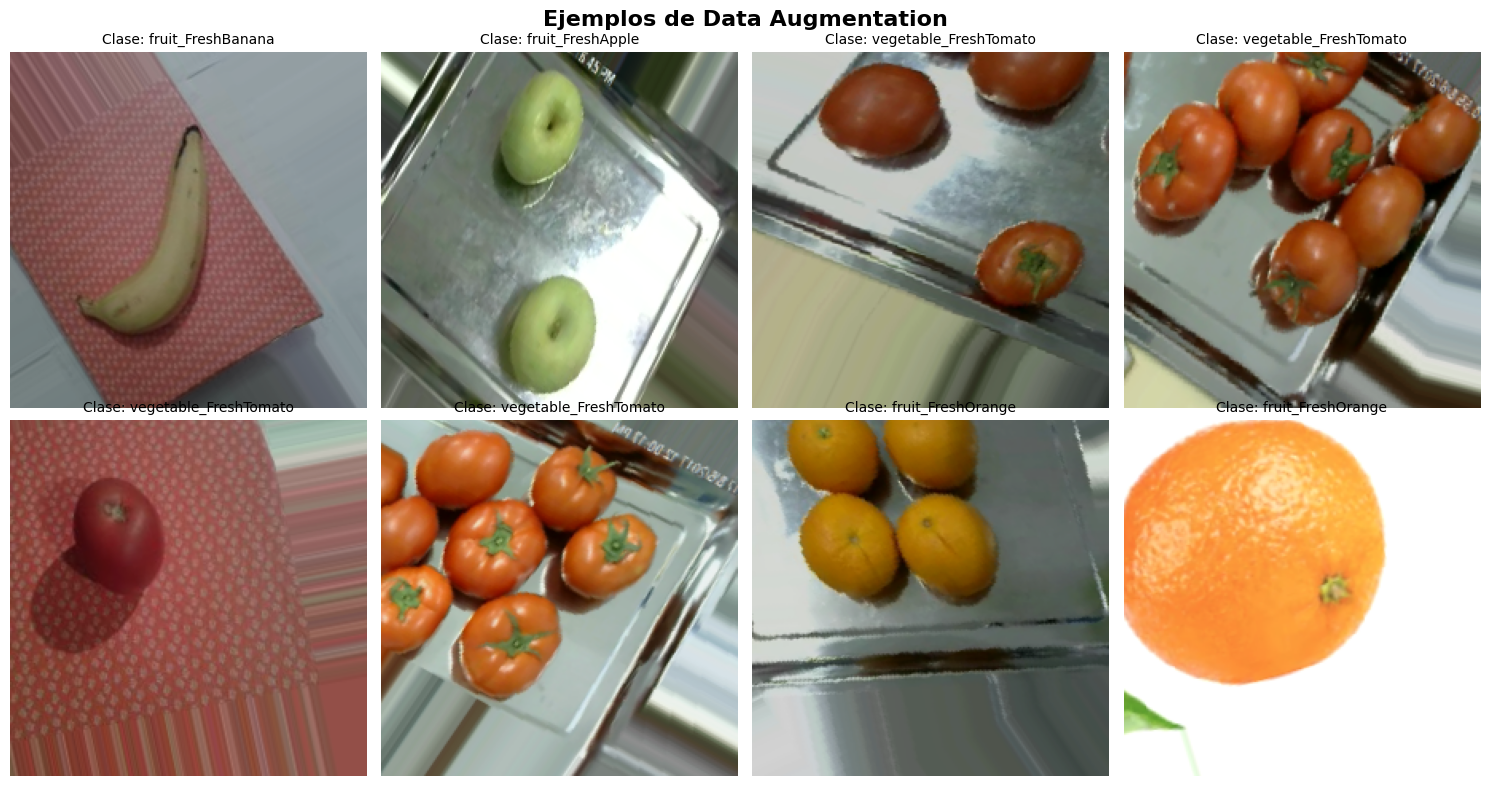

In [63]:
# Visualizar efectos del Data Augmentation
def visualize_augmentation(generator, num_samples=8):
    """Visualizar imágenes aumentadas"""
    batch = next(generator)
    images, labels = batch

    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    fig.suptitle('Ejemplos de Data Augmentation', fontsize=16, fontweight='bold')

    for i, ax in enumerate(axes.flat):
        if i < len(images):
            # Convertir a float32 para matplotlib y asegurar rango [0,1]
            img = images[i].astype(np.float32)
            img = np.clip(img, 0, 1)  # Asegurar que esté en rango [0,1]

            ax.imshow(img)

            # Encontrar la clase con mayor probabilidad
            class_idx = np.argmax(labels[i])
            class_name = list(train_generator.class_indices.keys())[class_idx]
            ax.set_title(f'Clase: {class_name}', fontsize=10)
            ax.axis('off')

    plt.tight_layout()
    plt.show()

print("=== VISUALIZACIÓN DE DATA AUGMENTATION ===")
visualize_augmentation(train_generator)

## Parte #2: Diseño y Entrenamiento de la Red Neuronal Convolucional

In [64]:
# Arquitectura 1: CNN Simple
def create_simple_cnn():
    """
    CNN Simple con arquitectura básica
    - 2 bloques convolucionales
    - Pocas capas densas
    - Dropout básico
    """
    model = Sequential([
        # Primer bloque convolucional
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
        MaxPooling2D(2, 2),

        # Segundo bloque convolucional
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),

        # Clasificador
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(NUM_CLASSES, activation='softmax')
    ])

    return model

# Crear y mostrar modelo simple
print("=== ARQUITECTURA 1: CNN SIMPLE ===")
model_simple = create_model_with_strategy(create_simple_cnn)
model_simple.summary()

# Compilar modelo dentro del scope de la estrategia
with strategy.scope():
    model_simple.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

print(f"\nParámetros totales: {model_simple.count_params():,}")
print("Características:")
print("- 2 bloques convolucionales (32, 64 filtros)")
print("- MaxPooling 2x2")
print("- 1 capa densa (128 neuronas)")
print("- Dropout: 0.5")
print("- Optimizador: Adam (lr=0.001)")

=== ARQUITECTURA 1: CNN SIMPLE ===


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │    23,888,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,908,166 (91.20 MB)

 Trainable params: 23,908,166 (91.20 MB)

 Non-trainable params: 0 (0.00 B)


Parámetros totales: 23,908,166
Características:
- 2 bloques convolucionales (32, 64 filtros)
- MaxPooling 2x2
- 1 capa densa (128 neuronas)
- Dropout: 0.5
- Optimizador: Adam (lr=0.001)


In [65]:
# Arquitectura 2: CNN Intermedia
def create_intermediate_cnn():
    """
    CNN Intermedia con más capas y regularización
    - 3 bloques convolucionales
    - Batch Normalization
    - Más capas densas
    - Dropout progresivo
    """
    model = Sequential([
        # Primer bloque convolucional
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.25),

        # Segundo bloque convolucional
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.25),

        # Tercer bloque convolucional
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.25),

        # Clasificador
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(NUM_CLASSES, activation='softmax')
    ])

    return model

# Crear y mostrar modelo intermedio
print("\n=== ARQUITECTURA 2: CNN INTERMEDIA ===")
model_intermediate = create_model_with_strategy(create_intermediate_cnn)
model_intermediate.summary()

# Compilar modelo dentro del scope de la estrategia
with strategy.scope():
    model_intermediate.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

print(f"\nParámetros totales: {model_intermediate.count_params():,}")
print("Características:")
print("- 3 bloques convolucionales (32, 64, 128 filtros)")
print("- Batch Normalization en cada bloque")
print("- Dropout progresivo (0.25 → 0.5)")
print("- 2 capas densas (512, 256 neuronas)")
print("- Optimizador: Adam (lr=0.001)")


=== ARQUITECTURA 2: CNN INTERMEDIA ===


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_32 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 220, 220, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 108, 108, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 108, 108, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 106, 106, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 51, 51, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 51, 51, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 80000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 512)            │    40,960,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,235,750 (157.30 MB)

 Trainable params: 41,234,278 (157.30 MB)

 Non-trainable params: 1,472 (5.75 KB)


Parámetros totales: 41,235,750
Características:
- 3 bloques convolucionales (32, 64, 128 filtros)
- Batch Normalization en cada bloque
- Dropout progresivo (0.25 → 0.5)
- 2 capas densas (512, 256 neuronas)
- Optimizador: Adam (lr=0.001)


In [66]:
# Arquitectura 3: CNN Avanzada
def create_advanced_cnn():
    """
    CNN Avanzada con arquitectura profunda
    - 4 bloques convolucionales
    - Filtros de diferentes tamaños
    - Global Average Pooling
    - Técnicas modernas de regularización
    """
    model = Sequential([
        # Primer bloque - filtros pequeños
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.2),

        # Segundo bloque - filtros medianos
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.3),

        # Tercer bloque - más filtros
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.4),

        # Cuarto bloque - filtros grandes
        Conv2D(256, (3, 3), activation='relu'),
        BatchNormalization(),
        Conv2D(256, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.4),

        # Global Average Pooling en lugar de Flatten
        layers.GlobalAveragePooling2D(),

        # Clasificador con menos parámetros gracias a GAP
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(NUM_CLASSES, activation='softmax')
    ])

    return model

# Crear y mostrar modelo avanzado
print("\n=== ARQUITECTURA 3: CNN AVANZADA ===")
model_advanced = create_model_with_strategy(create_advanced_cnn)
model_advanced.summary()

# Compilar modelo con configuración optimizada dentro del scope de la estrategia
with strategy.scope():
    model_advanced.compile(
        optimizer=Adam(learning_rate=0.0005),  # Learning rate más bajo
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

print(f"\nParámetros totales: {model_advanced.count_params():,}")
print("Características:")
print("- 4 bloques convolucionales (32, 64, 128, 256 filtros)")
print("- Batch Normalization en todos los bloques")
print("- Dropout progresivo (0.2 → 0.5)")
print("- Global Average Pooling")
print("- 2 capas densas (512, 256 neuronas)")
print("- Optimizador: Adam (lr=0.0005)")


=== ARQUITECTURA 3: CNN AVANZADA ===


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_37 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 220, 220, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 108, 108, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 108, 108, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 106, 106, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 51, 51, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 51, 51, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 49, 49, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 22, 22, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 22, 22, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 20, 20, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,441,702 (5.50 MB)

 Trainable params: 1,439,206 (5.49 MB)

 Non-trainable params: 2,496 (9.75 KB)


Parámetros totales: 1,441,702
Características:
- 4 bloques convolucionales (32, 64, 128, 256 filtros)
- Batch Normalization en todos los bloques
- Dropout progresivo (0.2 → 0.5)
- Global Average Pooling
- 2 capas densas (512, 256 neuronas)
- Optimizador: Adam (lr=0.0005)


In [67]:
# Configurar callbacks para el entrenamiento
def get_callbacks():
    """Configurar callbacks para optimizar el entrenamiento"""
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=1
        )
    ]
    return callbacks

# Función para entrenar y evaluar modelos
def train_and_evaluate_model(model, model_name, epochs=EPOCHS):
    """Entrenar un modelo y registrar resultados"""
    print(f"\n{'='*50}")
    print(f"ENTRENANDO: {model_name}")
    print(f"{'='*50}")

    # Obtener callbacks
    callbacks = get_callbacks()

    # Entrenar modelo
    history = model.fit(
        train_generator,
        steps_per_epoch=STEPS_PER_EPOCH,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=VALIDATION_STEPS,
        callbacks=callbacks,
        verbose=1
    )

    # Evaluar en datos de validación
    val_loss, val_accuracy = model.evaluate(validation_generator, verbose=0)

    print(f"\nRESULTADOS FINALES - {model_name}:")
    print(f"Pérdida de validación: {val_loss:.4f}")
    print(f"Precisión de validación: {val_accuracy:.4f}")

    return history, val_loss, val_accuracy

print("=== CONFIGURACIÓN DE ENTRENAMIENTO ===")
print("Callbacks configurados:")
print("- EarlyStopping: paciencia de 10 épocas")
print("- ReduceLROnPlateau: reduce LR por factor 0.5 cada 5 épocas sin mejora")
print("- Monitoreo: val_loss")

=== CONFIGURACIÓN DE ENTRENAMIENTO ===
Callbacks configurados:
- EarlyStopping: paciencia de 10 épocas
- ReduceLROnPlateau: reduce LR por factor 0.5 cada 5 épocas sin mejora
- Monitoreo: val_loss


In [68]:
# Entrenar Modelo 1: CNN Simple
history_simple, val_loss_simple, val_acc_simple = train_and_evaluate_model(
    model_simple,
    "CNN SIMPLE",
    epochs=30  # Menos épocas para modelo simple
)


ENTRENANDO: CNN SIMPLE
Epoch 1/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.2060 - loss: 5.6170 - val_accuracy: 0.4517 - val_loss: 1.3439 - learning_rate: 0.0010
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.4688 - loss: 1.4235 - val_accuracy: 0.4389 - val_loss: 1.3512 - learning_rate: 0.0010
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.4962 - loss: 1.3514 - val_accuracy: 0.5739 - val_loss: 1.1532 - learning_rate: 0.0010
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.5781 - loss: 1.1251 - val_accuracy: 0.6023 - val_loss: 1.1286 - learning_rate: 0.0010
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.6274 - loss: 1.0464 - val_accuracy: 0.7102 - val_loss: 0.8009 - learning_rate: 0.0010
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 0.7188 - loss: 0.8550 - val_accuracy: 0.7074 - val_loss: 0.7978 - learning_rate: 0.0010
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.6974 - 

In [69]:
# Entrenar Modelo 2: CNN Intermedia
history_intermediate, val_loss_intermediate, val_acc_intermediate = train_and_evaluate_model(
    model_intermediate,
    "CNN INTERMEDIA",
    epochs=40
)


ENTRENANDO: CNN INTERMEDIA
Epoch 1/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.2347 - loss: 2.8945 - val_accuracy: 0.1719 - val_loss: 11.0542 - learning_rate: 0.0010
Epoch 2/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.3906 - loss: 1.7988 - val_accuracy: 0.1690 - val_loss: 11.6113 - learning_rate: 0.0010
Epoch 3/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.4310 - loss: 1.9332 - val_accuracy: 0.1719 - val_loss: 9.3561 - learning_rate: 0.0010
Epoch 4/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.5938 - loss: 1.2285 - val_accuracy: 0.1705 - val_loss: 9.4350 - learning_rate: 0.0010
Epoch 5/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.6173 - loss: 1.2402 - val_accuracy: 0.1690 - val_loss: 8.1688 - learning_rate: 0.0010
Epoch 6/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.7344 - loss: 0.9145 - val_accuracy: 0.1719 - val_loss: 8.1198 - learning_rate: 0.0010
Epoch 7/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.6

In [70]:
# Entrenar Modelo 3: CNN Avanzada
history_advanced, val_loss_advanced, val_acc_advanced = train_and_evaluate_model(
    model_advanced,
    "CNN AVANZADA",
    epochs=EPOCHS
)


ENTRENANDO: CNN AVANZADA
Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.2335 - loss: 2.6919 - val_accuracy: 0.1676 - val_loss: 1.8802 - learning_rate: 5.0000e-04
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.5469 - loss: 1.5331 - val_accuracy: 0.1676 - val_loss: 1.8873 - learning_rate: 5.0000e-04
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.5127 - loss: 1.5284 - val_accuracy: 0.1676 - val_loss: 2.6975 - learning_rate: 5.0000e-04
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.5781 - loss: 1.1778 - val_accuracy: 0.1690 - val_loss: 2.8817 - learning_rate: 5.0000e-04
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.6483 - loss: 1.1068 - val_accuracy: 0.1733 - val_loss: 4.3896 - learning_rate: 5.0000e-04
Epoch 6/50
 1/46 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 0.6719 - loss: 0.9640
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step 

In [71]:
# Comparación de resultados
print("\n" + "="*80)
print("COMPARACIÓN DE RESULTADOS DE LAS 3 ARQUITECTURAS")
print("="*80)

# Crear DataFrame de comparación
results_df = pd.DataFrame({
    'Modelo': ['CNN Simple', 'CNN Intermedia', 'CNN Avanzada'],
    'Parámetros': [
        f"{model_simple.count_params():,}",
        f"{model_intermediate.count_params():,}",
        f"{model_advanced.count_params():,}"
    ],
    'Val_Loss': [val_loss_simple, val_loss_intermediate, val_loss_advanced],
    'Val_Accuracy': [val_acc_simple, val_acc_intermediate, val_acc_advanced]
})

print(results_df.to_string(index=False))

# Encontrar el mejor modelo
best_model_idx = np.argmax([val_acc_simple, val_acc_intermediate, val_acc_advanced])
best_model_names = ['CNN Simple', 'CNN Intermedia', 'CNN Avanzada']
best_models = [model_simple, model_intermediate, model_advanced]

print(f"\n🏆 MEJOR MODELO: {best_model_names[best_model_idx]}")
print(f"   Precisión de validación: {results_df.iloc[best_model_idx]['Val_Accuracy']:.4f}")
print(f"   Pérdida de validación: {results_df.iloc[best_model_idx]['Val_Loss']:.4f}")

best_model = best_models[best_model_idx]


COMPARACIÓN DE RESULTADOS DE LAS 3 ARQUITECTURAS
        Modelo Parámetros  Val_Loss  Val_Accuracy
    CNN Simple 23,908,166  0.465467      0.851296
CNN Intermedia 41,235,750  0.637240      0.804911
  CNN Avanzada  1,441,702  1.877788      0.169168

🏆 MEJOR MODELO: CNN Simple
   Precisión de validación: 0.8513
   Pérdida de validación: 0.4655


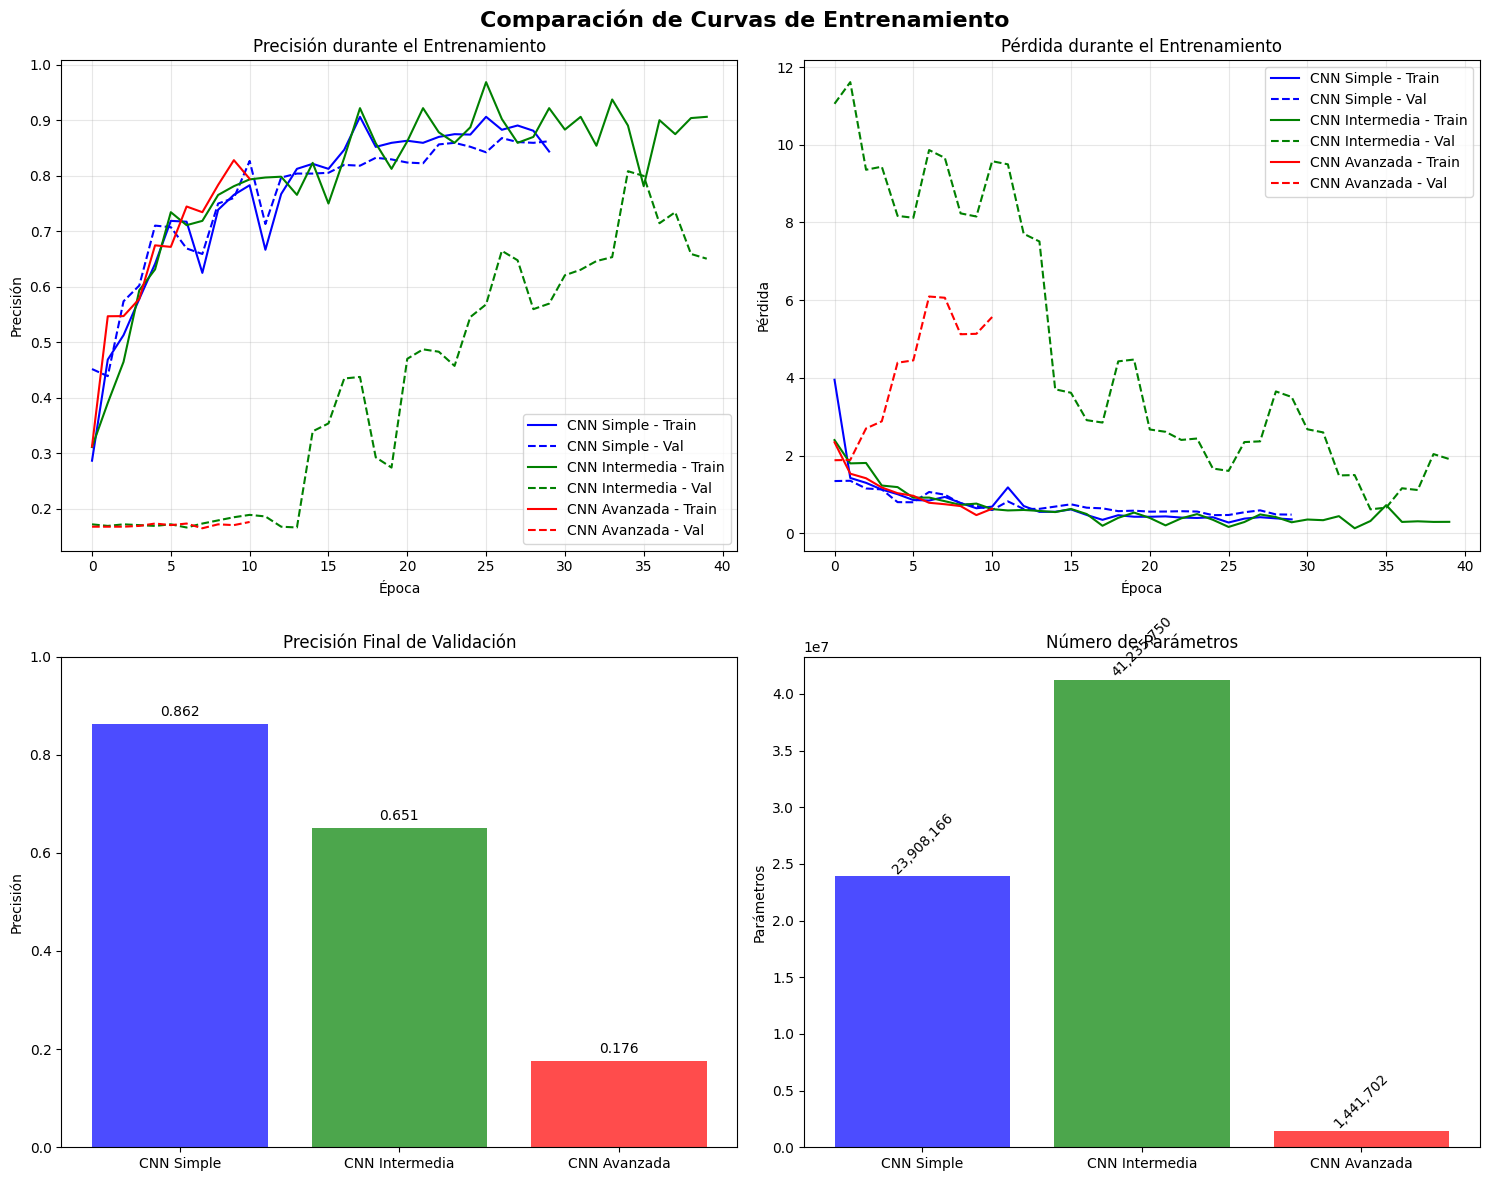

In [72]:
# Visualizar curvas de entrenamiento
def plot_training_history(histories, model_names):
    """Visualizar curvas de entrenamiento para todos los modelos"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Comparación de Curvas de Entrenamiento', fontsize=16, fontweight='bold')

    # Colores para cada modelo
    colors = ['blue', 'green', 'red']

    # Gráfico 1: Precisión de entrenamiento
    ax = axes[0, 0]
    for i, (history, name, color) in enumerate(zip(histories, model_names, colors)):
        ax.plot(history.history['accuracy'], label=f'{name} - Train', color=color, linestyle='-')
        ax.plot(history.history['val_accuracy'], label=f'{name} - Val', color=color, linestyle='--')
    ax.set_title('Precisión durante el Entrenamiento')
    ax.set_xlabel('Época')
    ax.set_ylabel('Precisión')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Gráfico 2: Pérdida de entrenamiento
    ax = axes[0, 1]
    for i, (history, name, color) in enumerate(zip(histories, model_names, colors)):
        ax.plot(history.history['loss'], label=f'{name} - Train', color=color, linestyle='-')
        ax.plot(history.history['val_loss'], label=f'{name} - Val', color=color, linestyle='--')
    ax.set_title('Pérdida durante el Entrenamiento')
    ax.set_xlabel('Época')
    ax.set_ylabel('Pérdida')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Gráfico 3: Comparación final de precisión
    ax = axes[1, 0]
    final_acc = [h.history['val_accuracy'][-1] for h in histories]
    bars = ax.bar(model_names, final_acc, color=colors, alpha=0.7)
    ax.set_title('Precisión Final de Validación')
    ax.set_ylabel('Precisión')
    ax.set_ylim(0, 1)

    # Agregar valores en las barras
    for bar, acc in zip(bars, final_acc):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{acc:.3f}', ha='center', va='bottom')

    # Gráfico 4: Número de parámetros
    ax = axes[1, 1]
    params = [
        model_simple.count_params(),
        model_intermediate.count_params(),
        model_advanced.count_params()
    ]
    bars = ax.bar(model_names, params, color=colors, alpha=0.7)
    ax.set_title('Número de Parámetros')
    ax.set_ylabel('Parámetros')

    # Agregar valores en las barras
    for bar, param in zip(bars, params):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{param:,}', ha='center', va='bottom', rotation=45)

    plt.tight_layout()
    plt.show()

# Generar gráficos
histories = [history_simple, history_intermediate, history_advanced]
model_names = ['CNN Simple', 'CNN Intermedia', 'CNN Avanzada']

plot_training_history(histories, model_names)

=== EVALUACIÓN DETALLADA DEL MEJOR MODELO ===
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 354ms/step


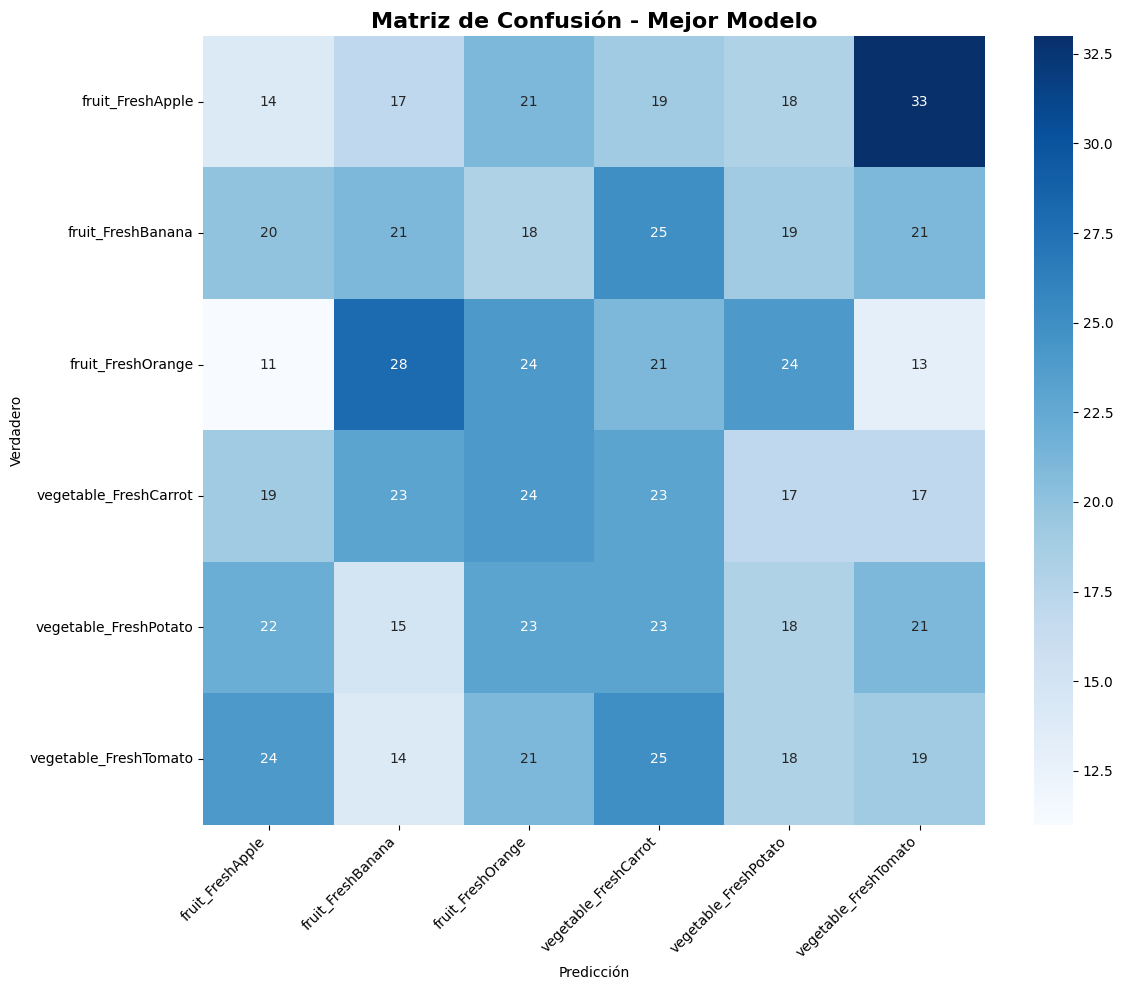


=== REPORTE DE CLASIFICACIÓN ===
                       precision    recall  f1-score   support

     fruit_FreshApple     0.1273    0.1148    0.1207       122
    fruit_FreshBanana     0.1780    0.1694    0.1736       124
    fruit_FreshOrange     0.1832    0.1983    0.1905       121
vegetable_FreshCarrot     0.1691    0.1870    0.1776       123
vegetable_FreshPotato     0.1579    0.1475    0.1525       122
vegetable_FreshTomato     0.1532    0.1570    0.1551       121

             accuracy                         0.1623       733
            macro avg     0.1614    0.1623    0.1617       733
         weighted avg     0.1615    0.1623    0.1617       733


Precisión general: 0.1623 (16.23%)


In [73]:
# Evaluación detallada del mejor modelo
def evaluate_model_detailed(model, validation_generator):
    """Evaluación detallada con matriz de confusión y métricas por clase"""

    # Predicciones
    validation_generator.reset()
    predictions = model.predict(validation_generator, verbose=1)
    predicted_classes = np.argmax(predictions, axis=1)

    # Obtener etiquetas verdaderas
    true_classes = validation_generator.classes
    class_labels = list(validation_generator.class_indices.keys())

    # Matriz de confusión
    cm = confusion_matrix(true_classes, predicted_classes)

    # Visualizar matriz de confusión
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Matriz de Confusión - Mejor Modelo', fontsize=16, fontweight='bold')
    plt.xlabel('Predicción')
    plt.ylabel('Verdadero')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # Reporte de clasificación
    print("\n=== REPORTE DE CLASIFICACIÓN ===")
    print(classification_report(true_classes, predicted_classes,
                              target_names=class_labels, digits=4))

    # Precisión general
    accuracy = accuracy_score(true_classes, predicted_classes)
    print(f"\nPrecisión general: {accuracy:.4f} ({accuracy*100:.2f}%)")

    return predictions, predicted_classes, true_classes

print("=== EVALUACIÓN DETALLADA DEL MEJOR MODELO ===")
predictions, predicted_classes, true_classes = evaluate_model_detailed(best_model, validation_generator)

In [74]:
# Visualizar predicciones del modelo
def visualize_predictions(model, validation_generator, num_images=12):
    """Visualizar predicciones del modelo con confianza"""

    # Obtener un batch de imágenes
    validation_generator.reset()
    batch = next(validation_generator)
    images, true_labels = batch

    # Hacer predicciones
    predictions = model.predict(images[:num_images])
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(true_labels[:num_images], axis=1)

    # Obtener nombres de clases
    class_names = list(validation_generator.class_indices.keys())

    # Crear visualización
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    fig.suptitle('Predicciones del Mejor Modelo', fontsize=16, fontweight='bold')

    for i, ax in enumerate(axes.flat):
        if i < num_images:
            # Mostrar imagen
            ax.imshow(images[i])

            # Obtener información de predicción
            true_class = class_names[true_classes[i]]
            pred_class = class_names[predicted_classes[i]]
            confidence = predictions[i][predicted_classes[i]]

            # Color basado en si la predicción es correcta
            color = 'green' if true_classes[i] == predicted_classes[i] else 'red'

            # Título con información
            title = f'Real: {true_class}\nPred: {pred_class}\nConf: {confidence:.3f}'
            ax.set_title(title, fontsize=10, color=color, fontweight='bold')
            ax.axis('off')
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

    # Estadísticas de confianza
    all_confidences = np.max(predictions, axis=1)
    correct_predictions = (predicted_classes == true_classes)

    print(f"\nEstadísticas de Confianza:")
    print(f"Confianza promedio: {np.mean(all_confidences):.3f}")
    print(f"Confianza en predicciones correctas: {np.mean(all_confidences[correct_predictions]):.3f}")
    print(f"Confianza en predicciones incorrectas: {np.mean(all_confidences[~correct_predictions]):.3f}")

print("=== VISUALIZACIÓN DE PREDICCIONES ===")
visualize_predictions(best_model, validation_generator)

=== VISUALIZACIÓN DE PREDICCIONES ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


ValueError: arrays must be of dtype byte, short, float32 or float64

<Figure size 1600x1200 with 12 Axes>


Estadísticas de Confianza:
Confianza promedio: 0.852
Confianza en predicciones correctas: 0.875
Confianza en predicciones incorrectas: 0.730
